## Setup

In [26]:
import random
from collections import Counter
from itertools import product, chain
import matplotlib.pyplot as plt
import seaborn as sb
import statistics
from scipy import stats

In [25]:
random.seed(0)
THRESHOLD = 15

## Create Deck

Objective is to create a Python list that represents a standard 52-card deck.

In [3]:
def create_deck():
    """
    Create a list that represents the card deck

    Cards are represented by a number according to the following rules:
    - Cards from 2 to 10 are represented by their number
    - Jacks, Queens, and Kings (court cards) are represented by the number 10
    - Aces are represented by 11

    Card suits (clubs, diamonds, hearts, and spades) don't matter in the game, so they're not recorded.
    """
    numeric_cards = range(2,11)
    value_court_cards = 10
    n_court_cards = 3
    value_ace = 11

    cards_in_a_suit = list(numeric_cards) + [value_court_cards]*n_court_cards + [value_ace]
    deck = 4 * cards_in_a_suit

    return deck

In [4]:
def check_deck(deck):
    """
    Check if the counts per value are correct
    
    The asserts will raise an exception if there's any issue.
    If it's alright, it'll simply print the last message.
    """
    numeric_cards_except_ten = range(2,10)

    assert len(deck) == 52, 'The deck must have 52 cards'
    counts = Counter(deck)
    for val in numeric_cards_except_ten:
        assert counts[val] == 4, \
            'There should be 4 of each numeric card from 2 to 9 inclusive'

    assert counts[10] == 4*4, \
        'There should be 16 with value 10. The 10 itself + 3 courd cards for each of the 4 suits'

    assert counts[11] == 4, \
        'There should 4 aces, which are represented by 11'
    print('Deck is ok')

In [5]:
def plot_histogram(deck):
    """
    Plot a bar plot of counts of each card value
    
    Doing a standard bar plot instead of a histogram because the X axis' ticks look nicer this way
    """
    counts = Counter(deck)

    # doing this instead of getting .keys() and .values() separately to make sure they're in the same order
    x, y = list(zip(*counts.items()))

    plt.bar(x, y)
    plt.title('Count of cards')
    plt.ylabel('No. of cards')
    _=plt.xlabel('Card value')

In [6]:
def main():
    deck = create_deck()
    check_deck(deck)
    plot_histogram(deck)

Deck is ok


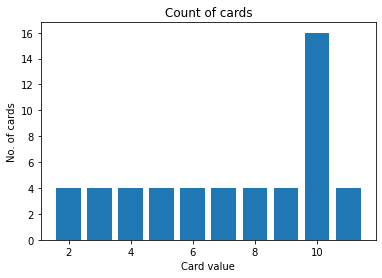

In [7]:
if __name__ == '__main__':
    main()

## Baseline Strategy

Create an empty list called “turn” and fill it up to start a for loop with 100,000 iterations, and then add each result to the list. In every loop, do the following:

- Shuffle the deck randomly.
- Pick the first 2 cards in the list as an initial hand to simulate taking the top 2 off the deck.
- If the sum of the initial hand equals 22, alter the first 11 with 1. We utilize 1 of our 2 aces as 1 in an effort to stay lower than 21. In such a situation of starting with 2 aces, “splitting” the hand is also an option; however, we will disregard this case in our simulation.
- If the sum of the hand is lower than 16, continue picking cards from the deck until the sum reaches or exceeds 16.
- If the sum of hand exceeds 21, check if there is an 11 in the hand and alter it with 1. After the altering, if the sum drops below 16, go to the previous step and continue picking cards.
- Add the total sum of the hand to the list as a result.

In [13]:
def alter_ace(hand):
    hand.remove(11)
    hand.append(1)
    return hand

In [10]:
def simulate_one_game():
    THRESHOLD = 16
    
    deck = create_deck()
    random.shuffle(deck)
    
    hand = [deck.pop(), deck.pop()]

    # there are exactly 2 aces
    # so use use of them as 1 instead of 11
    if sum(hand) == 22:
        hand = alter_ace(hand)

    while sum(hand) < THRESHOLD:
        hand.append(deck.pop())
        if sum(hand) > 21 and 11 in hand:
            hand = alter_ace(hand)
    
    return hand

In [11]:
def simulate_n_games(n=100):
    results = [sum(simulate_one_game()) for i in range(n)]

    sb.histplot(results, discrete=True)
        
    pct_wins = 100 * (len([x for x in results if x == 21]) / n)
    print(f'Won {pct_wins:.1f}% of the time')

Won 10.9% of the time


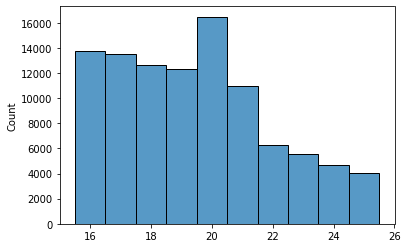

In [14]:
if __name__ == '__main__':
    simulate_n_games(100000)

## Battle Strategies

Let’s imagine two players at the same table, and each of them applies a different strategy with different thresholds. Define a new function called “duel_play” to simulate this scenario.
- It should have two arguments: Threshold 1 and Threshold 2.
- It should simulate a play between two players with different thresholds and return the winning player’s threshold.
- If there is no winner, return 0.
- Use the “simulate_game” function to simulate games for Threshold 1 and Threshold 2 in the “duel_play” function.
- In the beginning of the duel_play function , shuffle the deck of 52 and use it for both thresholds. Deal different cards to each simulation. For example, if the first simulation dealt with 3 cards, then discard these from the shuffled deck and continue with the remaining list.

Compete different strategies against each other, and in every turn, save the winner to a list.
- Create an empty list called "winners".
- For a threshold list in the range (10,20), run the duel_play function and make every element of the list play against others. At the end, you should get 100 plays.
- Repeat the previous step 10,000 times and save the winner thresholds to a list. At the end, the winner list should have a length of 100*10,000 = 1,000,000.

In [20]:
def simulate_one_game(deck, threshold):
    hand = [deck.pop(), deck.pop()]

    # there are exactly 2 aces
    # so use use of them as 1 instead of 11
    if sum(hand) == 22:
        hand = alter_ace(hand)

    while sum(hand) < threshold:
        hand.append(deck.pop())
        if sum(hand) > 21 and 11 in hand:
            hand = alter_ace(hand)
    
    return hand

In [21]:
def duel_play(threshold_1, threshold_2):
    """
    Simulate 2 strategies playing against each other
    
    Each strategy can have a different threshold for stopping.
    Cards are dealt first to one player until it finishes its game and then to the second.
    """
    deck = create_deck()
    random.shuffle(deck)
    
    sum_1 = sum(simulate_one_game(deck, threshold_1))
    sum_2 = sum(simulate_one_game(deck, threshold_2))

    winner = None

    if (sum_1 > 21 and sum_2 > 21) or sum_1 == sum_2:
        winner = 0
    elif sum_2 > 21:
        winner = threshold_1
    elif sum_1 > 21:
        winner = threshold_2
    # here I already know that both are smaller than 21 so I can check one against the other
    elif sum_1 > sum_2:
        winner = threshold_1
    elif sum_2 > sum_1:
        # or could be simply else I believe, but I'm being explicit
        winner = threshold_2

    return winner

In [22]:
def duel_all_combinations():
    """
    Duel all possible thresholds against each other
    
    Possible thresholds are from 10 to and including 19.
    """
    possible_thresholds = range(10, 20)
    all_possible_combinations = product(possible_thresholds, repeat=2)
    winners = [duel_play(threshold_1, threshold_2) for threshold_1, threshold_2 in all_possible_combinations]
    return winners

In [23]:
def run_simulation(n_simulations=100):
    """
    Run the simulations all vs all n times and plots a histogram of the winners
    """
    all_winners = list(chain(*(duel_all_combinations() for _ in range(n_simulations))))
    sb.histplot(all_winners, discrete=True)

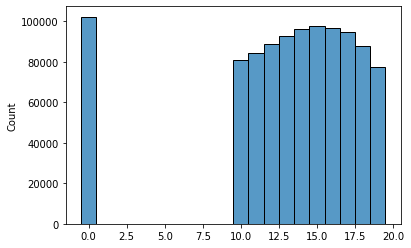

In [24]:
if __name__ == '__main__':
    run_simulation(10000)

## Calculate Confidence Intervals

- Create a list of frequency wins, which contains a 10,000 frequency of win for threshold = 15.
- Using the duel_play function from the previous milestone, simulate the play for threshold = 15 against an opponent, whose strategy is chosen randomly among thresholds of 13, 14, 16, and 17.
- Simulate this play 1,000 times, and at the end, calculate the win rate for threshold = 15 for non-tie cases. For example, in a game with 300 wins and 100 tie cases, the win rate would be 300/(1,000-100) = 0.33.
- Repeat the calculation in the previous step 10,000 times and append the results to the list called "frequency_wins".
- Visualize the histogram of the winners list.
- Check the distribution of the win probability histogram.
- Calculate the 95% confidence interval for the frequency_wins list.

In [27]:
def play_against_random_strategy(threshold, other_strategies=None):
    if other_strategies is None:
        other_strategies = [13, 14, 16, 17]
    opponent_threshold = random.choice(other_strategies)
    winner = duel_play(threshold, opponent_threshold)
    return winner

In [28]:
def simulate_n_individual_random_rounds(n_rounds):
    winners = [play_against_random_strategy(THRESHOLD) for _ in range(n_rounds)]
    winners_non_zero = [x for x in winners if x != 0]
    n_wins = len([x for x in winners if x == THRESHOLD])
    win_rate = n_wins / len(winners_non_zero)
    return win_rate

In [29]:
def repeat_simulation_m_times(n, m):
    """
    Simulate n games, repeating it m times for a total of n*m times with m output values
    """
    win_rates = [simulate_n_individual_random_rounds(n) for _ in range(m)]
    sb.histplot(win_rates, stat='probability')
    plt.xlabel('Win rate')
    plt.title('Histogram of win rate')
    return win_rates

In [30]:
def calculate_confidence_interval(win_rates):
    """
    Calculate confidence interval assuming the distribution is normal
    """
    alpha = .95
    mean_wins = statistics.mean(win_rates)
    confidence_interval = stats.norm.interval(alpha, mean_wins, statistics.stdev(win_rates))

    print(f'The mean win rate is {mean_wins:.2f} and the '\
          f'{alpha:.0%} confidence interval is [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')

The mean win rate is 0.51 and the 95% confidence interval is [0.48, 0.55]


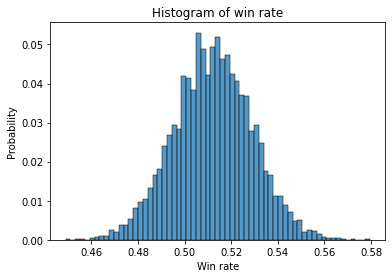

In [31]:
if __name__ == '__main__':
    win_rates = repeat_simulation_m_times(1000, 10000)
    calculate_confidence_interval(win_rates)